In [42]:
import numpy as np
import os
import sys
from math import sqrt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split
from scipy.special import expit, logit

from skimage.feature import hog


In [43]:
path = '/segmentation_WBC/dataset 1'
filepaths = [os.path.join(r,file) for r,d,f in os.walk(os.getcwd() + path) for file in f]
filepaths = [x for x in filepaths if x.endswith(".bmp")]

filepaths_2 = [os.path.join(r,file) for r,d,f in os.walk(os.getcwd() + path) for file in f]
filepaths_2 = [x for x in filepaths_2 if x.endswith(".png")]


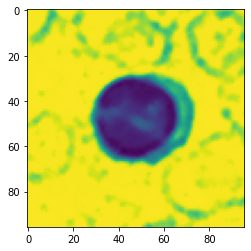

In [44]:
imglist = [ ]
imgalgo_list = [ ]
for i in filepaths:
    newsize = (96, 96)
    
    img_colored = Image.open(i)
    img_colored = img_colored.resize(newsize,Image.LANCZOS)
    
    img = img_colored.convert('L')
    img = np.array(img)
    
    fd, hog_image = hog(img_colored, orientations=9, pixels_per_cell=(4, 4),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)
    
    img_hog = np.array(hog_image)
    img_hog = img_hog.astype("float64")
    
    img_hog = img_hog.reshape(96*96)
    imglist.append(img)
    imgalgo_list.append(img_hog)

imglist = np.array(imglist)
imgalgo_list = np.array(imgalgo_list)
imgplot = plt.imshow(imglist[0])
plt.show()

In [45]:
Labels_Path = '/segmentation_WBC'
Labels_count = [ 0 , 0 , 0 , 0 , 0 ]
Real_Labels = [ ]
LabelsFilePath = [os.path.join(r,file) for r,d,f in os.walk(os.getcwd() + Labels_Path) for file in f]
LabelsFilePath = [x for x in LabelsFilePath if x.endswith(".csv")]

Labels = np.genfromtxt(LabelsFilePath[0],delimiter=',')

for i in Labels[1::,1]:
    Real_Labels.append(str(int(i)-1))
Real_Labels = np.array(Real_Labels)
for i in Real_Labels:
    if i == '0':
        Labels_count[0] += 1
    elif i == '1':
        Labels_count[1] += 1
    elif i == '2':
        Labels_count[2] += 1
    elif i == '3':
        Labels_count[3] += 1
    elif i == '4':
        Labels_count[4] += 1
        
ClassLabels = 5
Numbers = len(Real_Labels)

In [46]:
Numbers = Real_Labels.shape[0] 
y = Real_Labels.reshape(1, Numbers)

Y_new = np.eye(ClassLabels)[y.astype('int32')]

Y_new = Y_new.T.reshape(ClassLabels, Numbers)


In [47]:
def sigmoid(z):
    s = expit(z)
    return s

In [48]:
def compute_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

In [49]:
def feed_forward(X, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]

    cache["A1"] = sigmoid(cache["Z1"])

    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]

    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)


    return cache

In [50]:
def back_propagate(X, Y, params, cache):
    nearzero = sys.float_info.epsilon
    
    dZ2 = cache["A2"] - Y
    dW2 = (1./sqrt(m_batch*m_batch + nearzero*nearzero )) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./sqrt(m_batch*m_batch + nearzero*nearzero )) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./sqrt(m_batch*m_batch + nearzero*nearzero )) * np.matmul(dZ1, X.T)
    db1 = (1./sqrt(m_batch*m_batch + nearzero*nearzero )) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

In [51]:
#Editing the Data to what we want
X = np.copy(imgalgo_list)
Y = np.copy(Y_new)

digits = ClassLabels

m = int(0.6 * X.shape[0])
m_test = X.shape[0] - m

X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y[:,:m], Y[:,m:]


shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [52]:
#Algorithm
#hyperparameteres
n_x = X_train.shape[0]
n_h = 64
learning_rate = 0.001
beta = 0.9
batch_size = 2
batches = -(-m // batch_size)

# initialization
params = { "W1": np.random.randn(n_h, n_x) * np.sqrt(1. / n_x),
           "b1": np.zeros((n_h, 1)) * np.sqrt(1. / n_x),
           "W2": np.random.randn(digits, n_h) * np.sqrt(1. / n_h),
           "b2": np.zeros((digits, 1)) * np.sqrt(1. / n_h) }

V_dW1 = np.zeros(params["W1"].shape)
V_db1 = np.zeros(params["b1"].shape)
V_dW2 = np.zeros(params["W2"].shape)
V_db2 = np.zeros(params["b2"].shape)

# train
for i in range(9):

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]


    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache)

        V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
        V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
        V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
        V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

        params["W1"] = params["W1"] - learning_rate * V_dW1
        params["b1"] = params["b1"] - learning_rate * V_db1
        params["W2"] = params["W2"] - learning_rate * V_dW2
        params["b2"] = params["b2"] - learning_rate * V_db2

    cache = feed_forward(X_train, params)

    train_cost = compute_loss(Y_train, cache["A2"])
    cache = feed_forward(X_test, params)
    
    test_cost = compute_loss(Y_test, cache["A2"])
    
    predictions = np.argmax(cache["A2"], axis=0)
    labels = np.argmax(Y_test, axis=0)
    print("Epoch {}: training cost = {}, test cost = {} , Accuracy = {} ".format(i+1 ,
                                                                              train_cost, 
                                                                              test_cost,
                                                                            accuracy_score(predictions, labels)
                                                                            )
         )

print("Done.")

Epoch 1: training cost = 0.8653906072113949, test cost = 1.189008521993568 , Accuracy = 0.7 
Epoch 2: training cost = 0.7427721288344274, test cost = 1.172454320450285 , Accuracy = 0.65 
Epoch 3: training cost = 0.6593687020870413, test cost = 1.090139115811481 , Accuracy = 0.675 
Epoch 4: training cost = 0.5834173077563413, test cost = 1.276288085773643 , Accuracy = 0.525 
Epoch 5: training cost = 0.5028551169225328, test cost = 1.1129235796628023 , Accuracy = 0.6666666666666666 
Epoch 6: training cost = 0.46545318018946663, test cost = 1.1334574641057367 , Accuracy = 0.6333333333333333 
Epoch 7: training cost = 0.41128255595693336, test cost = 1.0968992804340871 , Accuracy = 0.6583333333333333 
Epoch 8: training cost = 0.3739063532777307, test cost = 1.0965593319327211 , Accuracy = 0.6666666666666666 
Epoch 9: training cost = 0.36520405986934873, test cost = 1.0273226133558742 , Accuracy = 0.7166666666666667 
Done.


In [53]:
cache = feed_forward(X_test, params)
predictions = np.argmax(cache["A2"], axis=0)
labels = np.argmax(Y_test, axis=0)
print("Final Accuracy Score: {} ".format(accuracy_score(predictions, labels)))
# [176, 53, 48, 22, 1]
# there is only 1 picture of label 5 which is extremely difficult for the neural network to work with

Final Accuracy Score: 0.7166666666666667 
